# 1. detect people

In [ ]:
# based on: https://www.youtube.com/watch?v=Pb3opEFP94U&t=813s
# based on: https://colab.research.google.com/drive/1x-eMvFQTLBTr7ho9ZlYkHF0NmyUyAlxT?usp=sharing#scrollTo=Z_pe5XFayoHP

### import libraries

In [102]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2 import model_zoo
from detectron2.structures import Boxes
from detectron2.structures import Keypoints
from PIL import Image

import detectron2
import cv2 as cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

### configure detector

In [103]:
def __init__(mode):
    """
    Method initializing a detector with a config file

    :param: mode: Select work mode (Object Detection, Keypoint Extraction)

    :return predictor and cfg objects
    """

    if mode == "OD":
        cfg_od = get_cfg()
        cfg_od.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
        cfg_od.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

        cfg_od.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
        cfg_od.MODEL.DEVICE = "cpu"
        predictor_od = DefaultPredictor(cfg_od)

        return predictor_od, cfg_od

    elif mode == "KP":
        cfg_kp = get_cfg()
        cfg_kp.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
        cfg_kp.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

        cfg_kp.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
        cfg_kp.MODEL.DEVICE = "cpu"
        predictor_kp = DefaultPredictor(cfg_kp)

        return predictor_kp, cfg_kp

predictor_od, cfg_od = __init__(mode="OD")

### define function responsible for detected class reduction to one

In [104]:
def chooseOneClassFromAllDetected(initialPredictions, image):
    """
    Method responsible for reducing detected object classes to one particular

    :param: initialPredictions: predictions produced by self.predictor which is DefaultPredictor(self.cfg)
    :param: image: image to be processed
    """

    classes = initialPredictions["instances"].pred_classes
    scores = initialPredictions["instances"].scores
    boxes = initialPredictions["instances"].pred_boxes

    index_to_keep = (classes == 0).nonzero().flatten().tolist()

    classes_filtered = torch.tensor(np.take(classes.cpu().numpy(), index_to_keep))
    scores_filtered = torch.tensor(np.take(scores.cpu().numpy(), index_to_keep))
    boxes_filtered = Boxes(
        torch.tensor(np.take(boxes.tensor.cpu().numpy(), index_to_keep, axis=0))
    )

    obj = detectron2.structures.Instances(
        image_size=(image.shape[0], image.shape[1])
    )
    obj.set("pred_classes", classes_filtered)
    obj.set("scores", scores_filtered)
    obj.set("pred_boxes", boxes_filtered)

    return obj

### load an image

In [105]:
def loadImage(imagePath, changeColorMode=True):
    """
    Method responsible for loading an image

    :param: imagePath: path to the image
    :param: changeColorMode: change BGR to RGB, useful when using both cv2 and matplotlib

    :return image object
    """

    image = cv2.imread(imagePath)
    if changeColorMode == True:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

image = loadImage(imagePath="images/Pedestrian-Deaths-India-Road-Fatalities-India-1280x720.jpeg", changeColorMode=True)

### perform detection and make prediction boxes

In [106]:
def performDetection(predictor, image, classReduction):
    """
    Method performing actual detection

    :param: predictor: predictor object
    :param: image: image object
    :param: classReduction: enables class reduction to one


    :return prediction, (optionally) new_predictions and prediction boxes objects
    """

    predictions = predictor(image)

    if classReduction == True:
        new_predictions = chooseOneClassFromAllDetected(initialPredictions=predictions, image=image)
        prediction_boxes = [x.numpy() for x in list(new_predictions.pred_boxes)]

        return predictions, new_predictions, prediction_boxes

    elif classReduction == False:

        return predictions

predictions_od, new_predictions_od, prediction_od_boxes = performDetection(predictor=predictor_od, image=image, classReduction=True)

### make visualization part and extract image with boxes

In [107]:
viz_od = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
output_od = viz_od.draw_instance_predictions(new_predictions_od.to("cpu"))

image_with_boxes = output_od.get_image()[:, :, ::-1]

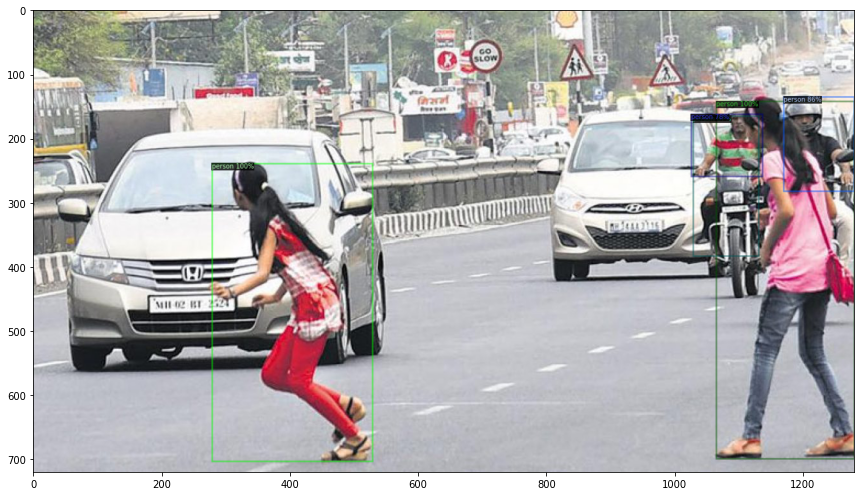

In [108]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(image_with_boxes)
plt.tight_layout()

# 2. cut part of the image from bounding boxes

In [41]:
# based on: https://stackoverflow.com/questions/68008935/crop-image-using-pred-boxes-coordinates

### define function responsible for cropping part of an image defined by bounding box coordinates

In [42]:
def cropImageByBoundingBox(image, box):
    """
    Function responsible for cropping part of an image defined by bounding box coordinates

    :param: image: image to be processed
    :param: box: numpy array with four box coordinates

    return: cropped image object
    """

    x_top_left = box[0]
    y_top_left = box[1]
    x_bottom_right = box[2]
    y_bottom_right = box[3]

    if type(image) == np.ndarray:
        image = Image.fromarray(image)
    crop_img = image.crop((int(x_top_left), int(y_top_left), int(x_bottom_right), int(y_bottom_right)))

    if type(image) == Image.Image:
        crop_img = np.array(crop_img)

    return crop_img, (x_top_left, y_top_left)

### perform exemplary cropping

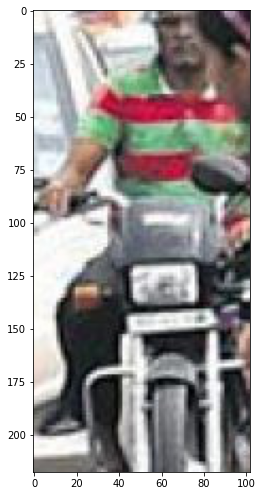

In [43]:
image_index = 2
image_cropped, cropped_image_coordinates = cropImageByBoundingBox(image, prediction_od_boxes[image_index])

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(image_cropped)
plt.tight_layout()

# 3. make individual skeletonization for each cropped image

### configure another detector (keypoint extraction)

In [44]:
predictor_kp, cfg_kp = __init__(mode="KP")

### make predictions

In [45]:
predictions_kp = performDetection(predictor=predictor_kp, image=image_cropped, classReduction=False)

/Users/michal/opt/anaconda3/envs/detectron2/lib/python3.8/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


### define function to filter detections to take only the best one

In [46]:
def chooseIndexOfBestKeypointInstanceFromAllDetected(predictions):
    """
    Method responsible for choosing the best (the longest in the sense of euclidean distance) detection instance

    :param: predictions: predictions produced by self.predictor which is DefaultPredictor(self.cfg)

    return index of the best (the longest in the sense of euclidean distance) prediction
    """

    # index = np.array([predictions["instances"][i].pred_keypoints.numpy().sum() for i in range(len(predictions["instances"].pred_keypoints.numpy()))])

    length = len(predictions["instances"].pred_keypoints.numpy())
    [predictions["instances"][i].pred_keypoints.numpy().sum() for i in range(length)]

    initial_predictions_all = predictions["instances"].pred_keypoints.numpy()
    index = np.array([])

    for prediction in initial_predictions_all:
        sum = 0
        for i in range(len(prediction)-1):
            sum += np.linalg.norm(prediction[i] - prediction[i+1])
        index = np.append(index, sum)

    if len(index) > 0:
        index_of_value_to_keep = np.argmax(index)
    else:
        index_of_value_to_keep = 0

    return int(index_of_value_to_keep)

### visualize results

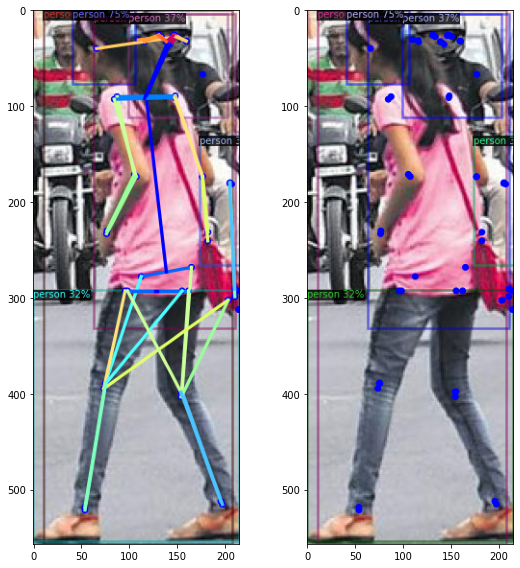

In [55]:
viz_kp = Visualizer(image_cropped[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
viz_kp_dots = Visualizer(image_cropped[:, :, ::-1], metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
index = chooseIndexOfBestKeypointInstanceFromAllDetected(predictions=predictions_kp)
if index == 0:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
    output_kp_dots = viz_kp_dots.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
else:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
    output_kp_dots = viz_kp_dots.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
image_skeletonized = output_kp.get_image()[:, :, ::-1]
image_skeletonized_dots = output_kp_dots.get_image()[:, :, ::-1]

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(image_skeletonized)
ax[1].imshow(image_skeletonized_dots)
plt.tight_layout()

In [18]:
# it seems that detecting people and making skeletons on a scene image (the initial one) gives better accuracy skeletonization
# compared to detecting people and making skeletonization on individual people

# 4. project individual masks on the initial picture

### projecion without coordinates correction

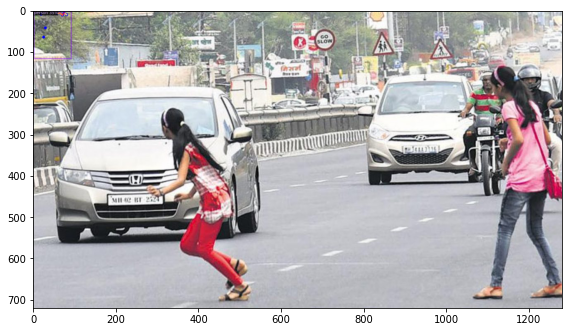

In [48]:
viz_kp = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
index = chooseIndexOfBestKeypointInstanceFromAllDetected(predictions=predictions_kp)
if index == 0:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
else:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
image_skeletonized = output_kp.get_image()[:, :, ::-1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_skeletonized)
plt.tight_layout()

### projecion with coordinates correction

In [49]:
def correctIndividualSkeletonCoordinates(initialPredictions, image, croppedImageCoordinates):
    """
    Method responsible for correction of individual detection (box, keypoints) coordinates to match initial picture position

    :param: initialPredictions: predictions produced by self.predictor which is DefaultPredictor(self.cfg)
    :param: image: cropped image
    :param: croppedImageCoordinates: cooridnates of the cropped image on the initiial one

    return corrected predictions (box, keypoints)
    """

    boxes = initialPredictions["instances"].pred_boxes
    boxes_filtered = boxes.tensor.cpu().numpy().copy()
    boxes_filtered[:,0] += croppedImageCoordinates[0]
    boxes_filtered[:,2] += croppedImageCoordinates[0]
    boxes_filtered[:,1] += croppedImageCoordinates[1]
    boxes_filtered[:,3] += croppedImageCoordinates[1]

    keypoints = initialPredictions["instances"].pred_keypoints
    keypoints_filtered = keypoints.cpu().numpy().copy()
    keypoints_filtered[:,:,0] += croppedImageCoordinates[0]
    keypoints_filtered[:,:,1] += croppedImageCoordinates[1]

    scores = initialPredictions["instances"].scores

    boxes_filtered = Boxes(torch.tensor(boxes_filtered))
    keypoints_filtered = torch.tensor(keypoints_filtered)

    obj = detectron2.structures.Instances(image_size=(image.shape[0], image.shape[1]))
    obj.set("pred_boxes", boxes_filtered)
    obj.set("pred_keypoints", keypoints_filtered)
    obj.set("scores", scores)

    return obj

In [50]:
new_preds = correctIndividualSkeletonCoordinates(initialPredictions=predictions_kp, image=image_cropped, croppedImageCoordinates=cropped_image_coordinates)

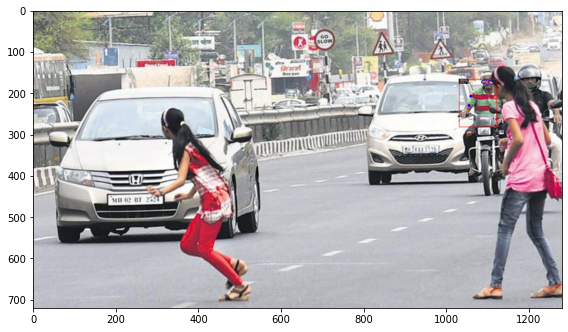

In [51]:
viz_kp = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)

if index == 0:
    output_kp = viz_kp.draw_instance_predictions(new_preds.to("cpu"))
else:
    output_kp = viz_kp.draw_instance_predictions(new_preds[index].to("cpu"))
image_skeletonized = output_kp.get_image()[:, :, ::-1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_skeletonized)
plt.tight_layout()

In [217]:
def combineAllPredictionsTogether(predictionsDict):
    """
    Method responsible for combining all predictions from individual images into one

    :param: predictionsDict: dictionary with predictions for each image

    return one combined prediction instance object
    """

    number_of_people = len(predictionsDict.keys())
    pred_sum = predictionsDict[0]
    boxes_sum = pred_sum.pred_boxes.tensor.cpu().numpy().copy()
    keypoints_sum = pred_sum.pred_keypoints.cpu().numpy().copy()
    scores_sum = pred_sum.scores.cpu().numpy().copy()

    if number_of_people > 1:
        for i in range(1, number_of_people-1):
            pred = predictionsDict[i]
            boxes = pred.pred_boxes.tensor.cpu().numpy().copy()
            keypoints = pred.pred_keypoints.cpu().numpy().copy()
            scores = pred.scores.cpu().numpy().copy()

            boxes_sum = np.vstack([boxes_sum, boxes])
            keypoints_sum = np.vstack([keypoints_sum, keypoints])
            scores_sum = np.append(scores_sum, scores)

    boxes_sum = Boxes(torch.tensor(boxes_sum))
    keypoints_sum = torch.tensor(keypoints_sum)

    obj = detectron2.structures.Instances(image_size=(image.shape[0], image.shape[1]))
    obj.set("pred_boxes", boxes_sum)
    obj.set("pred_keypoints", keypoints_sum)
    obj.set("scores", scores_sum)

    return obj

# put all together

/Users/michal/opt/anaconda3/envs/detectron2/lib/python3.8/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


Execution time was: 65.6537759999992  s


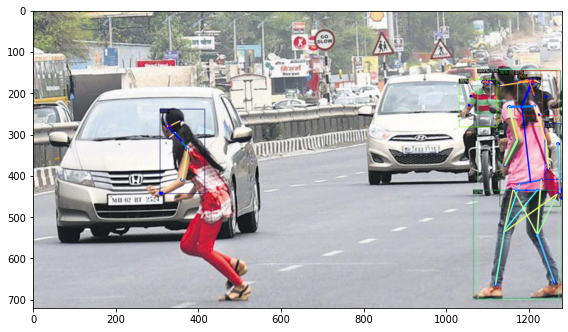

In [218]:
import timeit

start_time = timeit.default_timer()

# prepare detectors
## initialize OD detector
predictor_od, cfg_od = __init__(mode="OD")

## initialize KP detector
predictor_kp, cfg_kp = __init__(mode="KP")

# 0. load an image
imagePath = "images/Pedestrian-Deaths-India-Road-Fatalities-India-1280x720.jpeg"
image = loadImage(imagePath=imagePath, changeColorMode=True)

# 1. perform detection and make prediction boxes
(
    predictions_od,
    reduced_predictions_od,
    prediction_od_boxes,
) = performDetection(
    predictor=predictor_od, image=image, classReduction=True
)
## make visualization part
viz_od = Visualizer(
    image[:, :, ::-1],
    metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]),
    instance_mode=ColorMode.IMAGE,
)
output_od = viz_od.draw_instance_predictions(reduced_predictions_od.to("cpu"))
image_with_boxes = output_od.get_image()[:, :, ::-1]

number_of_people = len(reduced_predictions_od)
predictions_kp_all = {}
images_kp_all = {}
image_final = image.copy()

for person_index in range(number_of_people):
    # 2. cut part of the image from bounding boxes
    image_cropped, cropped_image_coordinates = cropImageByBoundingBox(
        image=image, box=prediction_od_boxes[person_index]
    )

    # 3. make individual skeletonization for the cropped image
    ## perform detection
    predictions_kp = performDetection(
        predictor=predictor_kp, image=image_cropped, classReduction=False
    )
    ## make visualization part
    viz_kp = Visualizer(
        image_cropped[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
    )
    index = chooseIndexOfBestKeypointInstanceFromAllDetected(predictions=predictions_kp)
    if index == 0:
        output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
    else:
        output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
    image_skeletonized = output_kp.get_image()[:, :, ::-1]

    # 4. project individual mask on the initial picture
    corrected_predictions = correctIndividualSkeletonCoordinates(
        initialPredictions=predictions_kp,
        image=image_cropped,
        croppedImageCoordinates=cropped_image_coordinates,
    )
    ## make visualization part
    viz_kp = Visualizer(
        image[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
    )
    if index == 0:
        output_kp = viz_kp.draw_instance_predictions(corrected_predictions.to("cpu"))
    else:
        output_kp = viz_kp.draw_instance_predictions(corrected_predictions[index].to("cpu"))
    image_skeletonized = output_kp.get_image()[:, :, ::-1]
    ## combine all results
    if index == 0:
      predictions_kp_all[person_index] = corrected_predictions.to("cpu")
    else:
      predictions_kp_all[person_index] = corrected_predictions[index].to("cpu")

    images_kp_all[person_index] = image_skeletonized

final_predictions = combineAllPredictionsTogether(predictionsDict=predictions_kp_all)
viz_kp = Visualizer(
        image[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
)
output_sum = viz_kp.draw_instance_predictions(final_predictions.to("cpu"))
image_sum = output_sum.get_image()[:, :, ::-1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_sum)
plt.tight_layout()

stop_time = timeit.default_timer()
time_execution_difference = stop_time - start_time
print("Execution time was:", time_execution_difference, " s")